In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline 
import matplotlib.pyplot as plt
import os
print(os.listdir("./"))


['.git', '.gitignore', '.vscode', 'captcha', 'captcha_5.ipynb', 'captcha_color', 'liscence_Plate (2) copy.ipynb', 'liscence_Plate (2).ipynb', 'ml_data_3188.csv', 'ml_test_3188.csv', 'notebookTD2.ipynb', 'notebookTDnewModel.ipynb', 'othersamples', 'plaquesimmat', 'samples']


In [3]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase+ "0123456789" # All symbols captcha can contain, lowercase and uppercase letters
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [26]:
print(num_symbols)

36


In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
def preprocess_data():
    n_samples = len(os.listdir('./captcha/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('./captcha/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('./captcha/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) == 5:
            # Scale and reshape image
            if img is not None:
                img = img / 255.0
                img = np.reshape(img, (50, 200, 1))
                # Define targets and code them using OneHotEncoding
                targs = np.zeros((5, num_symbols))
                for j, l in enumerate(pic_target):
                    ind = symbols.find(l)
                    targs[j, ind] = 1
                X[i] = img
                y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [6]:
model=create_model();
model.summary();




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 200, 16)          160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 100, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d[0][0]']

In [ ]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=25,verbose=1, validation_split=0.2)

Epoch 1/25


25/25 [==============================] - 7s 126ms/step - loss: 17.8824 - dense_1_loss: 3.4712 - dense_3_loss: 3.6200 - dense_5_loss: 3.5955 - dense_7_loss: 3.5812 - dense_9_loss: 3.6146 - dense_1_accuracy: 0.0709 - dense_3_accuracy: 0.0580 - dense_5_accuracy: 0.0683 - dense_7_accuracy: 0.0554 - dense_9_accuracy: 0.0541 - val_loss: 17.7097 - val_dense_1_loss: 3.6492 - val_dense_3_loss: 3.5155 - val_dense_5_loss: 3.5187 - val_dense_7_loss: 3.5147 - val_dense_9_loss: 3.5116 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0670 - val_dense_5_accuracy: 0.0979 - val_dense_7_accuracy: 0.0773 - val_dense_9_accuracy: 0.1392
Epoch 2/25
25/25 [==============================] - 2s 96ms/step - loss: 16.8032 - dense_1_loss: 3.2439 - dense_3_loss: 3.4348 - dense_5_loss: 3.4043 - dense_7_loss: 3.3875 - dense_9_loss: 3.3327 - dense_1_accuracy: 0.0722 - dense_3_accuracy: 0.0915 - dense_5_accuracy: 0.0941 - dense_7_accuracy: 0.0580 - dense_9_accuracy: 0.0954 - val_loss: 17.6122 -

In [8]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    print(f"Shape of model output: {res.shape}")

    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [10]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

overall_acc = sum(score[7:])/5
print(overall_acc)

4/4 [==============================] - 0s 19ms/step - loss: 18.9851 - dense_1_loss: 17.0037 - dense_3_loss: 0.1169 - dense_5_loss: 0.5452 - dense_7_loss: 0.9056 - dense_9_loss: 0.4139 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9802 - dense_5_accuracy: 0.8416 - dense_7_accuracy: 0.7525 - dense_9_accuracy: 0.8812
Test Loss and accuracy: [18.985122680664062, 17.00369644165039, 0.11685477942228317, 0.5451561808586121, 0.90555340051651, 0.41386324167251587, 0.0, 0.9801980257034302, 0.8415841460227966, 0.7524752616882324, 0.8811880946159363]
0.6910891056060791


['226md', '22d5n', '2356g', '23mdg', '23n88', '243mm', '244e2', '245y5', '24f6w', '24pew', '25257', '253dc', '25egp', '25m6p', '25p2m', '25w53', '264m5', '268g2', '28348', '28x47', '2b827', '2bg48', '2cegf', '2cg58', '2cgyx', '2en7g', '2enf4', '2fxgd', '2g783', '2g7nm', '2gyb6', '2mg87', '2mpnn', '2n73f', '2nbcx', '2nf26', '2npg6', '2nx38', '2p2y8', '2pfpn', '2w4y7', '2wc38', '2wx73', '2x7bm', '2xc2n', '2ycn8', '2yggg', '325fb', '32cnn', '32dnn', '33b22', '33f7m', '33n73', '33ng4', '33p4e', '34b84', '34fxm', '34pcn', '368y5', '36bc2', '36nx4', '36w25', '373gb', '377xx', '378e5', '37d52', '37ep6', '387g2', '38n57', '3b4we', '3bd8f', '3bfnd', '3bnyf', '3bx86', '3cpwb', '3d7bd', '3den6', '3dgmf', '3ebnn', '3ebpw', '3eny7', '3fbxd', '3g2w6', '3mxdn', '3n2b4', '3n3cf', '3n7mx', '3ndxd', '3nfdn', '3nnpw', '3nw7w', '3ny45', '3p4nn', '3p67n', '3pe4g', '3w2bw', '3wnd3', '3x325', '3x5fm', '3xcgg', '3xng6', '3ye2e', '3ygde', '3ym7f', '428b6', '42dw4', '42nxy', '42xpy', '43gey', '43mn5', '43p5d', 

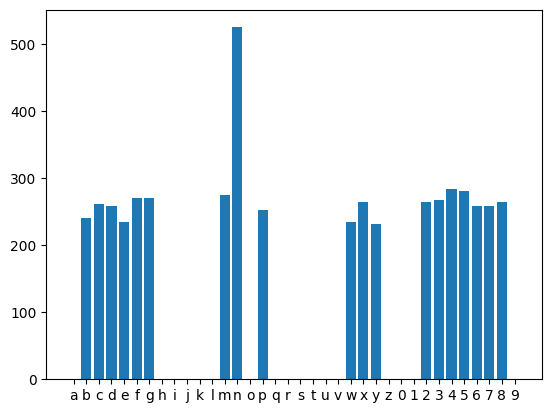

In [ ]:
#répartition des caractères pour le domaine A

def read_file_names():
    labels = []
    for filename in os.listdir('./captcha/samples'):
        if filename.endswith(".png"):
            labels.append(filename[:-4])
    return labels

a= read_file_names()
print(a)


#créer un dictionner à remplir avec les clés a-z 0-9 et initialiser les valeurs à 0

def create_alphabet_dict():
    alphabet = {}
    for char in string.ascii_lowercase:
        alphabet[char] = 0
    for char in string.digits:
        alphabet[char] = 0
    return alphabet


# à partir de create_alphabet_dict remplir les valeurs avec les occurences de chaque caractère

def fill_alphabet_dict(occurences):
    alphabet = create_alphabet_dict()
    for key in occurences:
        alphabet[key] = occurences[key]
    return alphabet

# calculer les occurences de chaque caractère
b = {}
for label in a:
    for char in label:
        if char in b:
            b[char] += 1
        else:
            b[char] = 1

c = fill_alphabet_dict(b)
print(c)

#afficher avec un histogramme la fréquence de chaque caractère

def plot_occurences(occurences):
    plt.bar(occurences.keys(), occurences.values())
    plt.show()

plot_occurences(c)


In [ ]:
#calcul de l'accuracy pour le domaine A

correct_predictions = [0] * 5
total_samples = 1070


for i, pic in enumerate(os.listdir('./captcha/samples')[:total_samples]):
    img = cv2.imread(os.path.join('./captcha/samples', pic), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
        img = np.reshape(img, (50, 200, 1))
        prediction = predict(os.path.join('./captcha/samples', pic))
        for j in range(5):
            if prediction[j] == pic[j]:
                correct_predictions[j] += 1


accuracies = [correct / total_samples for correct in correct_predictions]
overall_accuracy = sum(accuracies) / 5


print(f'Accuracy for each character: {[f"{acc * 100:.2f}%" for acc in accuracies]}')
print(f'Overall accuracy: {overall_accuracy * 100:.2f}%')


1/1 [==============================] - 0s 28ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 28ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 32ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 37ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 32ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 31ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 30ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 34ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 30ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 60ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 49ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 39ms/step
Sh

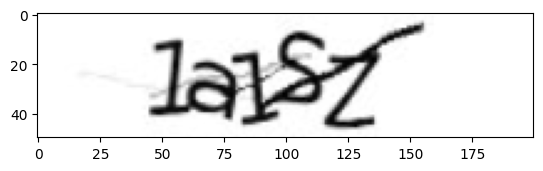

In [ ]:
def resize_image(image_path):
    # Lire l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
   
    # Vérifier si l'image a été correctement lue
    if img is None:
        print("Erreur lors de la lecture de l'image.")
        return None
   
    # Redimensionner l'image à 200x40
    resized_img = cv2.resize(img, (200, 50))
   
    return resized_img


# Exemple d'utilisation
image_path = './captcha_color/1a1SZ.jpg'
resized_image = resize_image(image_path)


# Afficher l'image redimensionnée
plt.imshow(resized_image, cmap='gray')
plt.show()
#afficher l'immage d'origine
# Create the directory if it doesn't exist
os.makedirs('./imageCouleur_resize', exist_ok=True)


# Process the first 1000 images in the /captcha_color directory
for i, pic in enumerate(os.listdir('./captcha_color')[:113062]):
    image_path = os.path.join('./captcha_color', pic)
    resized_image = resize_image(image_path)
    if resized_image is not None:
        # Save the resized image to the new directory
        cv2.imwrite(os.path.join('./imageCouleur_resize', pic), resized_image)



In [ ]:
#calcul de l'accuracy pour le domaine B

correct_predictions = [0] * 5
total_samples = 1070


for i, pic in enumerate(os.listdir('./imageCouleur_resize')[:total_samples]):
    img = cv2.imread(os.path.join('./imageCouleur_resize', pic), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
        img = np.reshape(img, (50, 200, 1))
        prediction = predict(os.path.join('./imageCouleur_resize', pic))
        for j in range(5):
            if prediction[j] == pic[j]:
                correct_predictions[j] += 1


accuracies = [correct / total_samples for correct in correct_predictions]
overall_accuracy = sum(accuracies) / 5


print(f'Accuracy for each character: {[f"{acc * 100:.2f}%" for acc in accuracies]}')
print(f'Overall accuracy: {overall_accuracy * 100:.2f}%')


1/1 [==============================] - 0s 27ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 28ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 26ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 33ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 29ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 29ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 30ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 24ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 27ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 26ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 26ms/step
Shape of model output: (5, 1, 36)
1/1 [==============================] - 0s 27ms/step
Sh

In [17]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('./captcha/samples/2b827.png'))
print(predict('./captcha/samples/2w4y7.png'))
print(predict('./captcha/samples/5nxnn.png'))
print(predict('./captcha/samples/5x7x5.png'))
print(predict('./captcha/samples/8n62n.png'))
print(predict('./captcha/samples/bf52c.png'))


1/1 [==============================] - 0s 32ms/step
Shape of model output: (5, 1, 36)
2b827
1/1 [==============================] - 0s 32ms/step
Shape of model output: (5, 1, 36)
2w4y7
1/1 [==============================] - 0s 35ms/step
Shape of model output: (5, 1, 36)
5nxnn
1/1 [==============================] - 0s 28ms/step
Shape of model output: (5, 1, 36)
5x7x5
1/1 [==============================] - 0s 27ms/step
Shape of model output: (5, 1, 36)
8n62n
1/1 [==============================] - 0s 29ms/step
Shape of model output: (5, 1, 36)
bf52c


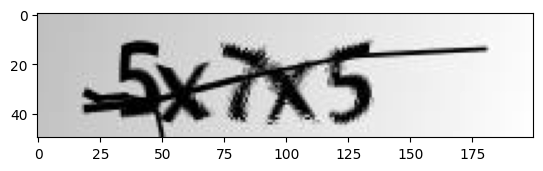

In [18]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('./captcha/samples/5x7x5.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [19]:
#Lets Predict By Model
print("Predicted Captcha =",predict('./captcha/samples/5x7x5.png'))

1/1 [==============================] - 0s 31ms/step
Shape of model output: (5, 1, 36)
Predicted Captcha = 5x7x5


In [40]:
model.save('captcha_model.h5')

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
